### Before

#### Об этом ноутбуке
Данный ноутбук является финальной частью.
Он аккумулирует в себе предыдущие два + исследует решения коллег по цеху, для улучшения навыков в будущем.

#### Цели данного ноутбука:
- Провести "работу над ошибками" после участия [соревновании](https://www.kaggle.com/competitions/adengi-internship);
- Подробно разобрать различные методы, которые используют коллеги для анализа ио бработки данных (методы заимствованы из этих ноутбуков: [Ноутбук1](https://www.kaggle.com/code/korcy78/baseline), [Ноутбук2](https://www.kaggle.com/code/alexaali/catboost-0-91-score))

#### Description
В этом соревновании вам нужно будет натренировать модель оттока, которая лучше всех сможет генерализовать общую зависимость оттока.

#### Evaluation
Ответы модели будут оценены с помощью F1 метрики между предсказанными ответами и реальными.

#### Первые мысли
По сути стандартная задача бинарной классификаци.

Необходимо предсказать отток клиентов.

В зависимости от кол-ва данных, будем выбирать модель.

Предварительно, как многим известно, в подобных задачах себя очень хорошо зарекомендовали бустинги.
Я взглянул на файлик train.csv, он весит 2.2Гб, данных много, я думаю лучшим решением будут именно бустинги.

Но, т.к. я практикуюсь, мне не важно какой скор я выбью, лично мне важно попробовать разные подходы и поэкспериментировать.

Разумеется в рамках разумных сроков(решаю эту задачу только по выходным).

#### О данных
- monthly_income - среднемесячный заработок клиента (зарплата)
- payment_frequency - частота получения зарплаты (month - 1 раз в месяц, 2 weeks - раз в две недели, и тд)
- status - статус клиента (самозанятый, рабочий, и тд)
- work_experience - кол-во лет стажа клиента
- client_type - тип клиента (новый, повторный)
- settlement - город клиента
- requested_sum - запрашиваемая сумма клиента для займа, если interface - alfa
- region - регион клиента (область, округ, и тд)
- loan_id - уникальный идентификатор займа
- client_id - уникальный идентификатор клиента
- main_agreement_amount - основная одобренная сумма клиенту по займу (может быть больше, чем approved_amount)
- main_agreement_term - основной одобренный срок по займу
- requested_period_days - запрашиваемый срок по займу
- requested_amount - запрашиваемая сумма клиента по займу
- req_app_amount - разница между запрашиваемой суммой займа и одобренной
- approved_amount - одобренная сумма по займу
- source - канал привлечения клиента
- first_source - первый канал привлечения клиента
- period_days - период страховки по займу
- interface - интерфейс, откуда пришла заявка - (site, mobile)
- created_at - дата открытия займа
- type - тип займа (тип продукта)
- closed_at - дата закрытия займа
- days_finish_loan - время в днях, затраченное на закрытие займа (closed_at - created_at)
- gender - пол клиента
- ag - возраст клиента
- repayment_type - Тип комиссии по займу (с 2.5% - with_comission, 5% - with_big_comission, 0% - no_comission)
- loan_order - порядковый номер займа
- have_extension - имеется ли пролонгация по данному займу
- cnt_ext - кол-во пролонгаций по займу
- start_dt - дата начала (список) пролонгаций по займу
- term - срок пролонгации (список)
- price - цена пролонгации (список)
- elecs_sum - штрафы, пени
- recurents_sum - штрафы, пени (там вроде как различия в этапах их начисления)
- tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
- issues - сумма просрочек, штрафов и пени
- principal - сумма основного долга
- interest - прибыль с клиента
- overdue_interest - прибыль с клиента, если есть прослойка
- overdue_fee - штрафы в просрочек
- contact_cases - кол-во обращений клиента с коллекшн
- nbki_score - скор клиента от рисков

- churn - колонка таргета

### Imports

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from category_encoders.cat_boost import CatBoostEncoder


import catboost as cb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight


from sklearn.metrics import accuracy_score, classification_report, f1_score

import time
import warnings
from tqdm import tqdm
from datetime import datetime

from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")



# Utilities
from rapidfuzz import process, fuzz
from sklearn.base import BaseEstimator, TransformerMixin
import re
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

### Загрузка данных

In [89]:
start = time.time()
train = pd.read_csv('./data/train.csv')
elapsed = time.time() - start
print(f'Time is: {elapsed} seconds')

Time is: 19.543049097061157 seconds


In [90]:
start = time.time()
test = pd.read_csv('./data/test.csv')
elapsed = time.time() - start
print(f'Time is: {elapsed} seconds')

Time is: 5.8990089893341064 seconds


#### Оптимизация данных

In [91]:
def optimize_data(df):
    # оптимизируем числовые данные
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    # Оптимизируем даты
    df["created_at"] = pd.to_datetime(df["created_at"])
    df["start_dt"] = pd.to_datetime(df["start_dt"])

    return df

In [92]:
# Размер трейна до оптимизации
print(f"Размер датасета до оптимизации: {train.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
train = optimize_data(train)
# Размер трейна после оптимизации
print(f"Размер датасета после оптимизации: {train.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета до оптимизации: 3231.96 MB
Размер датасета после оптимизации: 2150.51 MB


In [93]:
# Размер теста до оптимизации
print(f"Размер датасета до оптимизации: {test.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
test = optimize_data(test)
# Размер теста после оптимизации
print(f"Размер датасета после оптимизации: {test.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Размер датасета до оптимизации: 971.89 MB
Размер датасета после оптимизации: 619.54 MB


### EDA

### Общая оценка

In [96]:
train.shape

(4036207, 45)

In [97]:
test.shape

(1348743, 43)

Количество фичей в трейне и тесте различно больше чем на единицу, следовательно из теста удалили некий признак, который остался в трейне.

Оставлять его не имеет никакого смысла абсолютно)

Ознакомимся с данными детальнее

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 45 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   monthly_income         float32       
 1   work_experience        float32       
 2   requested_sum          float32       
 3   main_agreement_amount  float32       
 4   main_agreement_term    float32       
 5   requested_period_days  float32       
 6   requested_amount       float32       
 7   req_app_amount         float32       
 8   approved_amount        float32       
 9   period_days            float32       
 10  days_finish_loan       float32       
 11  ag                     float32       
 12  cnt_ext                float32       
 13  term                   float32       
 14  price                  float32       
 15  elecs_sum              float32       
 16  recurents_sum          float32       
 17  tamount                float32       
 18  issues                

In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   monthly_income         1348680 non-null  float32       
 1   work_experience        463225 non-null   float32       
 2   requested_sum          163790 non-null   float32       
 3   main_agreement_amount  1348743 non-null  float32       
 4   main_agreement_term    1348743 non-null  float32       
 5   requested_period_days  1200882 non-null  float32       
 6   requested_amount       1209772 non-null  float32       
 7   req_app_amount         1209772 non-null  float32       
 8   approved_amount        1348743 non-null  float32       
 9   period_days            1348743 non-null  float32       
 10  days_finish_loan       1348743 non-null  float32       
 11  ag                     1348743 non-null  float32       
 12  cnt_ext                15170

In [94]:
# лишним является 'closed_at', без зазрений совести дропаем его из трейна
train.drop('closed_at', axis=1, inplace=True)

In [95]:
# избавимся от 'client_type.1' ,т.к. это категориальная копия 'client_type'
train.drop('client_type.1', axis=1, inplace=True)
test.drop('client_type.1', axis=1, inplace=True)

#### DataClean

In [97]:
class DataCleanerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, region_column=None, region_reference=None):
        self.missing_cols = []
        self.region_column = region_column
        self.region_reference = region_reference
        self.reference_list = []
        self.label_encoders = {}

    def fit(self, X, y=None):
        # Сохраняем список колонок с пропущенными значениями для добавления индикаторов
        self.missing_cols = X.columns[X.isnull().any()].tolist()

        if self.region_column and self.region_reference:
            reference = pd.read_csv(self.region_reference)
            reference["region_name"] = reference["name"].str.lower().str.strip()
            self.reference_list = reference["region_name"].tolist()

        return self

    def transform(self, X):
        data = X.copy()
        
        # Добавляем индикаторы пропущенных значений перед заполнением пропусков
        data = self.add_missing_indicators(data)

        # Применяем функции для заполнения пропущенных значений
        data = self.fill_monthly_income(data)
        data = self.fill_work_experience(data)
        data = self.fill_requested_sum(data)
        data = self.fill_requested_amount_and_req_app_amount(data)
        data = self.fill_requested_period_days(data)
        data = self.fill_term_and_price(data)
        data = self.fill_elecs_sum_and_recurents_sum(data)
        data = self.fill_tamount(data)
        data = self.fill_nbki_score(data)
        data = self.fill_cnt_ext(data)
        data = self.fill_start_dt(data)
        data = self.fill_contact_cases(data)

        if self.region_column:
            data[self.region_column] = data[self.region_column].str.lower().str.strip()
            data[self.region_column] = data[self.region_column].apply(self.find_closest_match)

        data = self.process_settlement(data)

        # Генерация новых признаков
        data = self.generate_features(data)

        # Обработка дат
        data = self.process_dates(data)

        # Преобразование категориальных переменных
        data = self.encode_categorical_features(data)

        # Удаление ненужных признаков
        data = self.delete_bad_features(data)

        return data

    def fill_monthly_income(self, data):
        data['monthly_income'] = data.groupby('status')['monthly_income'].transform(
            lambda x: x.fillna(x.median()) if not np.isnan(x.median()) else x.fillna(data['monthly_income'].median())
        )
        return data

    def fill_work_experience(self, data):
        data['work_experience'] = data.groupby('status')['work_experience'].transform(
            lambda x: x.fillna(x.median()) if not np.isnan(x.median()) else x.fillna(data['work_experience'].median())
        )
        return data

    def fill_requested_sum(self, data):
        data['requested_sum'] = data['requested_sum'].fillna(
            data['approved_amount'] * (data['requested_sum'].median() / data['approved_amount'].median())
        )
        return data

    def fill_requested_amount_and_req_app_amount(self, data):
        data['requested_amount'] = data['requested_amount'].fillna(data['requested_sum'])
        data['req_app_amount'] = data['requested_amount'] - data['approved_amount']
        return data

    def fill_requested_period_days(self, data):
        data['requested_period_days'] = data.groupby('type')['requested_period_days'].transform(
            lambda x: x.fillna(x.median())
        )
        return data

    def fill_term_and_price(self, data):
        data['term'] = data['term'].fillna(0)
        data['price'] = data['price'].fillna(0)
        return data

    def fill_elecs_sum_and_recurents_sum(self, data):
        data['elecs_sum'] = data.groupby('repayment_type')['elecs_sum'].transform(
            lambda x: x.fillna(x.median())
        )
        data['recurents_sum'] = data.groupby('repayment_type')['recurents_sum'].transform(
            lambda x: x.fillna(x.median())
        )
        return data

    def fill_tamount(self, data):
        data['tamount'] = data['tamount'].fillna(data['principal'] + data['interest'] + data['issues'])
        return data

    def fill_nbki_score(self, data):
        data['nbki_score'] = data.groupby('status')['nbki_score'].transform(
            lambda x: x.fillna(x.median())
        )
        return data

    def fill_cnt_ext(self, data):
        data['cnt_ext'] = data['cnt_ext'].fillna(0)
        return data

    def add_missing_indicators(self, data):
        for col in self.missing_cols:
            data[f'{col}_missing'] = data[col].isnull().astype(int)
        return data

    def fill_contact_cases(self, data):
        data['contact_cases'] = data.groupby('repayment_type')['contact_cases'].transform(
            lambda x: x.fillna(x.median())
        )
        data['contact_cases'] = data['contact_cases'].fillna(data['contact_cases'].median())
        return data

    def fill_start_dt(self, data):
        data['start_dt'] = pd.to_datetime(data['start_dt'], errors='coerce')
        data['start_dt'] = data.groupby('client_id')['start_dt'].transform(
            lambda x: x.fillna(x.min())
        )
        data['start_dt'] = data['start_dt'].fillna(data['created_at'])
        return data

    def find_closest_match(self, region):
        match = process.extractOne(region, self.reference_list, scorer=fuzz.ratio)
        return match[0] if match and match[1] >= 60 else region  # Минимальный порог схожести - 60%

    def generate_features(self, data):
        # Платежное поведение
        data['payment_to_income_ratio'] = data['tamount'] / data['monthly_income']
        data['interest_to_principal_ratio'] = data['interest'] / data['principal']
        data['overdue_ratio'] = (data['overdue_interest'] + data['overdue_fee']) / data['principal']

        # Временные характеристики
        data['early_repayment'] = data['period_days'] - data['days_finish_loan']

        # Кредитное поведение
        data['approval_ratio'] = data['approved_amount'] / data['requested_amount']
        data['previous_extensions'] = data['cnt_ext'].fillna(0)
        data['had_extensions'] = data['cnt_ext'].notna().astype(int)

        # Признаки рискованности клиента
        data['risk_score'] = (
            (data['nbki_score'] * -1) +  # Инвертируем скор, чтобы высокие значения означали высокий риск
            (data['overdue_ratio'] * 2) +
            (data['had_extensions'] * 1.5)
        )

        # Поведенческие признаки
        data['digital_engagement'] = ((data['interface'] == 2) |
                                        (data['source'].isin([11, 12]))).astype(int)
        data['prefers_longer_terms'] = (data['requested_period_days'] > 
                                          data['requested_period_days'].mean()).astype(int)

        # Группируем по client_id и создаем новые признаки
        client_features = data.groupby('client_id').agg({
            'loan_id': 'count',  # Общее количество займов
            'days_finish_loan': 'mean',  # Средний срок закрытия займа
            'approved_amount': 'mean',  # Средняя сумма займа
            'cnt_ext': 'sum',  # Общее количество продлений
            'elecs_sum': 'sum',  # Сумма штрафов
            'created_at': 'max',  # Дата последнего займа
            'monthly_income': 'std',  # Вариация дохода
            'contact_cases': 'sum'  # Количество обращений в поддержку
        }).reset_index()

        client_features.rename(columns={
            'loan_id': 'total_loans',
            'days_finish_loan': 'avg_days_finish_loan',
            'approved_amount': 'avg_approved_amount',
            'cnt_ext': 'total_extensions',
            'elecs_sum': 'total_fees',
            'created_at': 'last_loan_date',
            'monthly_income': 'income_variation',
            'contact_cases': 'total_contacts'
        }, inplace=True)
        data = data.merge(client_features, on='client_id', how='left')
        
        # Финансовая нагрузка
        data['total_debt_burden'] = (data['elecs_sum'] + data['recurents_sum']) / data['monthly_income']
        data['disposable_income_ratio'] = 1 - data['total_debt_burden']

        return data

    def process_dates(self, data):
        date_columns = ['created_at', 'start_dt']
        for col in date_columns:
            if col in data.columns:
                data[col] = pd.to_datetime(data[col], errors='coerce')  # Преобразуем в datetime
                data[col] = data[col].fillna(data['start_dt'])  # Заполняем отсутствующие значения датой из 'start_dt'
                # Преобразуем datetime в формат timestamp (количество секунд с начала эпохи)
                data[col] = data[col].astype('int64') // 10**9
        return data

    def encode_categorical_features(self, data):
        categorical_features = ['status', 'payment_frequency', 'source', 'first_source', 
                                'interface', 'type', 'repayment_type', 'settlement', 'region', 'gender']

        for feature in categorical_features:
            data[feature] = data[feature].astype(str).fillna("missing")  # Используем строку, чтобы избежать ошибки
            le = LabelEncoder()
            data[feature] = le.fit_transform(data[feature])
            self.label_encoders[feature] = le

        return data

    def clean_city_name(self, name):
        # Извлечение последнего слова
        name = name.split()[-1].lower().strip()
        # Удаление нежелательных символов (всего, что не буквы и не цифры)
        name = re.sub(r'[^а-яa-z0-9]', '', name)
        
        return name

    def process_settlement(self, data):
        data['settlement'] = data['settlement'].apply(self.clean_city_name)
        threshold = 400
        data_region_counts = data['settlement'].value_counts()
        data['settlement'] = data['settlement'].apply(lambda x: x if data_region_counts[x] > threshold else 'другие')

        return data

    def delete_bad_features(self, data):
        columns = ['loan_id', 'client_id']
        data.drop(columns=columns, inplace=True)
        
        return data

In [98]:
# Пример использования
start_time = time.time()
transformer = DataCleanerTransformer(
    region_column="region", region_reference="./data/region.csv"
)
# Файл region_reference содержит правильно написанные названия регионов, исправление работает, так что, находятся 
# ближайше возможные записи из region_reference и по ним заменяются записи из train и test

train = transformer.fit_transform(train)
test = transformer.fit_transform(test)

end_time = time.time()
elapsed_time = round(end_time - start_time, 2)
print(f"\nElapsed Time: {elapsed_time} seconds")


Elapsed Time: 346.88 seconds


### TrainModel

In [101]:
X = train.drop(columns=["churn"])
y = train["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [102]:
%%time
# Настройка модели
model = CatBoostClassifier(verbose=False, 
                           random_seed=42,
                           auto_class_weights="Balanced")

# Параметры для GridSearch
param_grid = {
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8],
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Оптимизируем F1-метрику
    cv=5,          # Стратифицированная кросс-валидация
    verbose=2,
    n_jobs=4      # Использую половину доступных ядер, дабы не убить ядро)
)

# Обучение GridSearch
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и метрик
print("\nЛучшие параметры: ", grid_search.best_params_)
print("Лучший F1-скор на кросс-валидации: ", grid_search.best_score_)

# Оценка на валидационных данных
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nОтчет о классификации на валидационных данных:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ............................depth=4, iterations=100; total time= 1.1min
[CV] END ............................depth=4, iterations=500; total time= 4.8min
[CV] END ............................depth=4, iterations=100; total time= 1.1min
[CV] END ............................depth=4, iterations=100; total time= 1.1min
[CV] END ............................depth=4, iterations=500; total time= 4.6min
[CV] END ............................depth=4, iterations=100; total time= 1.1min
[CV] END ............................depth=4, iterations=500; total time= 4.7min
[CV] END ............................depth=4, iterations=500; total time= 4.7min
[CV] END ............................depth=4, iterations=100; total time= 1.1min
[CV] END ............................depth=4, iterations=500; total time= 4.8min
[CV] END ...........................depth=4, iterations=1000; total time= 9.2min
[CV] END ...........................depth=4, iter

### Submission

In [108]:
# forgot loan_id =)
start = time.time()
test_for_loan_id = pd.read_csv('./data/test.csv')
elapsed = time.time() - start
print(f'Time is: {elapsed} seconds')

Time is: 6.562875509262085 seconds


In [110]:
loan_id_test = test_for_loan_id['loan_id']

In [113]:
def submission(model, test_df, loan_id_submission, target_column='churn', output_prefix='submission_baseline'):
    # Предсказания на тестовых данных
    y_pred_test = model.predict(test_df)

    # Подготовка DataFrame для сохранения
    submission = pd.DataFrame({
        'loan_id': loan_id_submission,
        'churn': y_pred_test
    })

    # Формирование имени файла
    model_name = type(model).__name__
    output_file = f"{output_prefix}_{model_name}.csv"

    # Сохранение файла
    submission.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в файл: {output_file}")


In [114]:
best_model = grid_search.best_estimator_  # Это ваша лучшая модель
submission(best_model, test, loan_id_test)

Предсказания сохранены в файл: submission_baseline_CatBoostClassifier.csv


Total score is: 0.90

### Важность прищнаков

In [115]:
# Получаем важность признаков
feature_importances = best_model.get_feature_importance()

# Создаем DataFrame с признаками и их важностью
feature_names = X_train.columns  # Здесь X_train - это DataFrame с признаками
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выводим топ-10 самых важных признаков
print(importance_df.head(10))


             Feature  Importance
65       total_loans   35.436169
35        loan_order   33.847448
71  income_variation    8.342554
72    total_contacts    5.055944
38        created_at    4.647810
31       client_type    4.436390
70    last_loan_date    4.238795
27      first_source    0.806671
26            source    0.775094
39          start_dt    0.748526


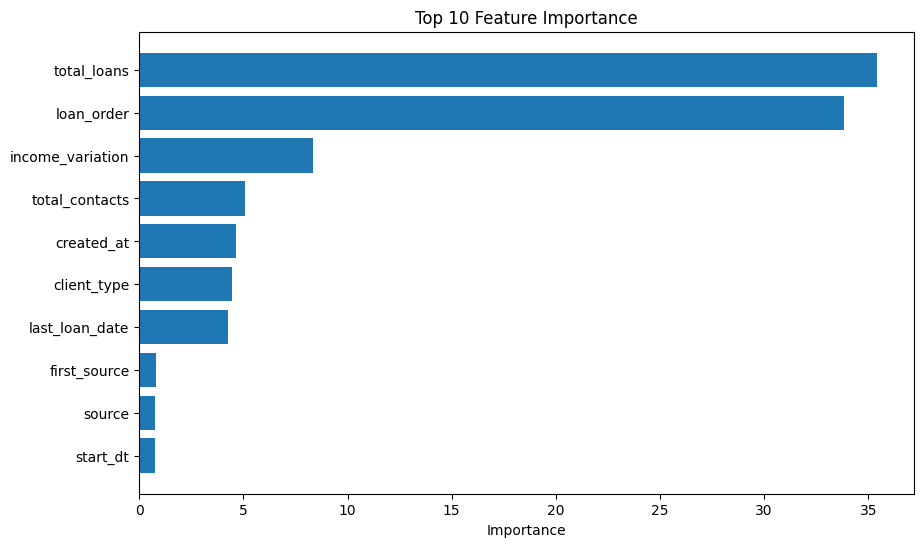

In [123]:
# Сортируем DataFrame по важности признаков (по убыванию)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализация 10 самых важных признаков
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Чтобы наиболее важные признаки были сверху
plt.show()